In [51]:
import torch
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import importlib
from simple_cnn import SimpleCNN
import finetuning_cnn
importlib.reload(finetuning_cnn)
from finetuning_cnn import FineTuningCNN
from custom_cnn import CustomCNN
import resnet_arcface
importlib.reload(resnet_arcface)
from resnet_arcface import ArcFaceNet


In [52]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(5),           # Piccole rotazioni ±5°
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Traslazioni leggere
    transforms.ColorJitter(brightness=0.1, contrast=0.1),        # Leggera variazione luminosità/contrasto
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [53]:
# --- Dataset base (senza transform) ---
dataset = ImageFolder(root='../../IAM+RIMES')  # nessuna transform qui

# --- Carica lo split ---
split = torch.load('splits/IAM+RIMES.pth')
train_indices = split['train_indices']
test_indices = split['test_indices']
label_map = split['label_map']

# --- Applica lo split ---
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, test_indices)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform, label_map):
        self.subset = subset
        self.transform = transform
        self.label_map = label_map  # dizionario {label_originale: label_ricodificato}
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if label in self.label_map:
            mapped_label = self.label_map[label]
        else:
            # Label non autorizzata, assegna -1 o altra label "speciale"
            mapped_label = -1
        return self.transform(img), mapped_label

    def __len__(self):
        return len(self.subset)
    
# --- Applica le trasformazioni specifiche ---
train_data = TransformedSubset(train_subset, transform, label_map)

# --- Calcola il numero di classi a partire dal training set ---
all_labels = [label for _, label in train_subset]

num_classes = len(label_map)
print(f"Numero di classi (utenti autorizzati): {num_classes}")

val_data = TransformedSubset(val_subset, transform, label_map)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Numero di classi (utenti autorizzati): 100


In [61]:
# Caricamento del modello
model_path = 'base_model.pth'
model_id_number = 1
#model = torch.load(model_path, map_location=torch.device('cpu'))
#model.eval()

# Load Dataset
data_dir = "../../IAM+RIMES"
dataset = ImageFolder(root=data_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
if model_id_number == 1:
    model = SimpleCNN(num_classes=num_classes)
elif model_id_number == 2:
    #fine tuning model
    model = FineTuningCNN(num_classes=num_classes)
elif model_id_number == 3:
    #second architecture model
    model = CustomCNN(num_classes)
elif model_id_number == 4:
    #fourth architecture model
    model = ArcFaceNet(num_classes=num_classes).to(device)
else:
    print("Invalid model_id_number")

In [63]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

SimpleCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Evaluate baseline model (before than ArcFace)

In [64]:

from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    auc, precision_score, recall_score, f1_score, confusion_matrix
)
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import torch

def evaluate_base_model(model, val_loader, threshold=0.5, device='cpu', print_summary=True, plot_roc=True):
    model.eval()
    total_auth = total_unauth = 0
    correct_auth = correct_total = 0
    false_accepts = false_rejects = 0

    confidences_correct = []
    confidences_incorrect = []

    all_preds = []
    all_labels = []
    all_confs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, dim=1)

            for i in range(labels.size(0)):
                label = labels[i].item()
                conf = max_probs[i].item()
                pred = predicted[i].item()

                # Applichiamo la soglia
                final_pred = pred if conf >= threshold else -1

                all_preds.append(final_pred)
                all_labels.append(label)
                all_confs.append(conf)

                # Metriche principali
                if label == -1:  # Non autorizzato
                    total_unauth += 1
                    if final_pred != -1:
                        false_accepts += 1
                        confidences_incorrect.append(conf)
                    else:
                        confidences_correct.append(conf)
                else:  # Autorizzato
                    total_auth += 1
                    if final_pred == label:
                        correct_auth += 1
                        confidences_correct.append(conf)
                    else:
                        false_rejects += 1
                        confidences_incorrect.append(conf)

                if (label != -1 and final_pred == label) or (label == -1 and final_pred == -1):
                    correct_total += 1

    # Valori binari: 1 = autorizzato, 0 = non autorizzato
    y_true = np.array([1 if l != -1 else 0 for l in all_labels])
    y_pred = np.array([1 if p != -1 else 0 for p in all_preds])
    y_scores = np.array(all_confs)

    # Metriche di classificazione
    overall_acc = 100 * correct_total / (total_auth + total_unauth) if (total_auth + total_unauth) > 0 else 0
    auth_acc = 100 * correct_auth / total_auth if total_auth > 0 else 0
    far = 100 * false_accepts / total_unauth if total_unauth > 0 else 0
    frr = 100 * false_rejects / total_auth if total_auth > 0 else 0
    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    cm = confusion_matrix(y_true, y_pred)

    avg_conf_correct = np.mean(confidences_correct) if confidences_correct else 0
    avg_conf_incorrect = np.mean(confidences_incorrect) if confidences_incorrect else 0

    # ROC & PR Curve
    roc_auc = roc_auc_score(y_true, y_scores)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall_curve, precision_curve)

    if print_summary:
        print(f"\n--- Evaluation Results ---")
        print(f"Threshold: {threshold}")
        print(f"Authorized Accuracy: {auth_acc:.2f}%")
        print(f"False Accept Rate (FAR): {far:.2f}%")
        print(f"False Reject Rate (FRR): {frr:.2f}%")
        print(f"Overall Accuracy: {overall_acc:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall (TPR): {recall:.2f}%")
        print(f"F1 Score: {f1:.2f}%")
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"PR AUC: {pr_auc:.2f}")
        print(f"Avg Confidence (Correct): {avg_conf_correct:.2f}")
        print(f"Avg Confidence (Incorrect): {avg_conf_incorrect:.2f}")
        print(f"Confusion Matrix:\n{cm}")

    # Output strutturato per eventuali plot successivi
    return {
        'authorized_accuracy': auth_acc,
        'far': far,
        'frr': frr,
        'overall_accuracy': overall_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'avg_conf_correct': avg_conf_correct,
        'avg_conf_incorrect': avg_conf_incorrect,
        'all_confs': all_confs,
        'all_labels': all_labels,
        'confusion_matrix': cm.tolist(),
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'roc_thresholds': roc_thresholds.tolist(),
        'precision_curve': precision_curve.tolist(),
        'recall_curve': recall_curve.tolist(),
        'pr_thresholds': pr_thresholds.tolist()
    }


In [65]:
def print_evaluation_metrics(metrics):
    print("\n📊  EVALUATION SUMMARY")
    print("-" * 40)
    print(f"{'Authorized Accuracy':25}: {metrics['authorized_accuracy']:.2f}%")
    print(f"{'False Accept Rate (FAR)':25}: {metrics['far']:.2f}%")
    print(f"{'False Reject Rate (FRR)':25}: {metrics['frr']:.2f}%")
    print(f"{'Overall Accuracy':25}: {metrics['overall_accuracy']:.2f}%")
    print()
    print(f"{'Precision':25}: {metrics['precision']:.2f}%")
    print(f"{'Recall':25}: {metrics['recall']:.2f}%")
    print(f"{'F1 Score':25}: {metrics['f1']:.2f}%")
    print()
    print(f"{'Avg Confidence (Correct)':25}: {metrics['avg_conf_correct']:.3f}")
    print(f"{'Avg Confidence (Incorrect)':25}: {metrics['avg_conf_incorrect']:.3f}")
    print("-" * 40)


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels=['Non-Auth', 'Auth']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("🔍 Confusion Matrix (Binary: Auth vs Non-Auth)")
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


In [67]:
def plot_metric_bars(metrics):
    names = ['Authorized Acc.', 'FAR', 'FRR', 'Overall Acc.', 'Precision', 'Recall', 'F1 Score']
    values = [
        metrics['authorized_accuracy'],
        metrics['far'],
        metrics['frr'],
        metrics['overall_accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1']
    ]

    colors = ['green', 'red', 'red', 'blue', 'orange', 'orange', 'purple']

    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color=colors)
    plt.title("📈 Key Evaluation Metrics")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [68]:
def plot_evaluation_curves(metrics, title_prefix="Validation"):
    # Controllo che i dati necessari siano presenti
    if not all(key in metrics for key in ['fpr', 'tpr', 'precision_curve', 'recall_curve', 'roc_auc', 'pr_auc']):
        print("Metriche ROC/PR incomplete, impossibile plottare.")
        return

    fpr = metrics['fpr']
    tpr = metrics['tpr']
    precision_curve = metrics['precision_curve']
    recall_curve = metrics['recall_curve']
    roc_auc = metrics['roc_auc']
    pr_auc = metrics['pr_auc']

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate (FAR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, label=f"AUC = {pr_auc:.2f}", color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [69]:
def full_evaluation_report(metrics):
    print_evaluation_metrics(metrics)
    plot_evaluation_curves(metrics)
    plot_confusion_matrix(metrics['confusion_matrix'])
    plot_metric_bars(metrics)


In [70]:
def plot_far_frr_vs_threshold_from_scores(y_true, y_scores):
    """
    Plot FAR and FRR in funzione della soglia.
    y_true: np.array, 1 = autorizzato, 0 = non autorizzato
    y_scores: np.array, confidenza del modello (es. softmax max probability)
    """
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    far = fpr * 100
    frr = (1 - tpr) * 100

    # Equal Error Rate (dove FAR ≈ FRR)
    eer_idx = np.nanargmin(np.abs(far - frr))
    eer_threshold = thresholds[eer_idx]
    eer = (far[eer_idx] + frr[eer_idx]) / 2

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, far, label="FAR (False Accept Rate)", color='red')
    plt.plot(thresholds, frr, label="FRR (False Reject Rate)", color='blue')
    plt.axvline(x=eer_threshold, linestyle='--', color='gray', label=f"EER Threshold = {eer_threshold:.2f}")
    plt.axhline(y=eer, linestyle='--', color='green', label=f"EER = {eer:.2f}%")

    plt.xlabel("Threshold")
    plt.ylabel("Error Rate (%)")
    plt.title("FAR and FRR vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


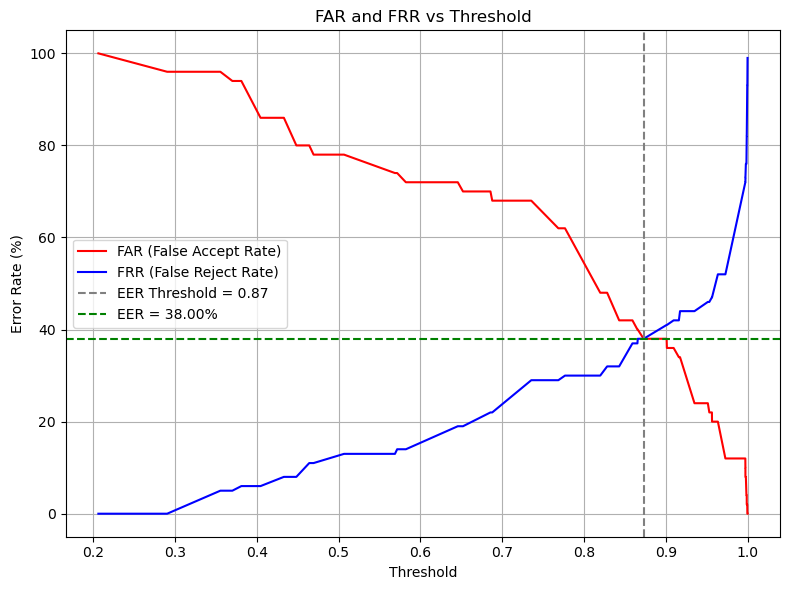

In [72]:
y_true = [1 if l != -1 else 0 for l in metrics['all_labels']]
y_scores = metrics['all_confs']
plot_far_frr_vs_threshold_from_scores(np.array(y_true), np.array(y_scores))

Evaluate ArcFace Model

In [ ]:
Retrieve metrics given a treshold value

In [ ]:
'''
def evaluate_arcface_fixed(model, val_loader, threshold=0.6, device='cpu',
                           mode='softmax', s=None, print_summary=True, return_raw=False):
    """
    Evaluation robusta per modelli con ArcFace.
    mode: 'softmax' (default) -> usa probabilità softmax sui logits (coerente con il training)
          'cosine' -> usa cosθ calcolato da embeddings e pesi della head (range ~[-1,1])
    s: scaling factor (se serve per convertire logits -> cosθ quando il modello restituisce logits = cosθ * s)
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_confs = []

    total_auth = total_unauth = 0
    correct_auth = correct_total = 0
    false_accepts = false_rejects = 0

    confidences_correct = []
    confidences_incorrect = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits, embeddings = model(images, labels=None)  # <-- unpack tuple
            probs = F.softmax(logits, dim=1)  # softmax su logits (s*cosθ)
            max_probs, predicted = torch.max(probs, 1)

            for pred, label, conf in zip(predicted, labels, max_probs):
                label, pred, conf = label.item(), pred.item(), conf.item()

                if conf < threshold:  # threshold sulle softmax probs
                    pred = -1

                all_preds.append(pred)
                all_labels.append(label)
                all_confs.append(conf)

                if label == -1:  # impostore
                    total_unauth += 1
                    if pred != -1:
                        false_accepts += 1
                        confidences_incorrect.append(conf)
                    else:
                        confidences_correct.append(conf)
                else:  # genuino
                    total_auth += 1
                    if pred == label:
                        correct_auth += 1
                        confidences_correct.append(conf)
                    else:
                        false_rejects += 1
                        confidences_incorrect.append(conf)

                if (label != -1 and pred == label) or (label == -1 and pred == -1):
                    correct_total += 1

    # Binary labels per impostor detection: 1 = autorizzato, 0 = impostore
    y_true = np.array([1 if l != -1 else 0 for l in all_labels])
    y_pred = np.array([1 if p != -1 else 0 for p in all_preds])
    y_scores = np.array(all_confs)

    overall_acc = 100 * correct_total / (total_auth + total_unauth) if (total_auth + total_unauth) > 0 else 0
    auth_acc = 100 * correct_auth / total_auth if total_auth > 0 else 0
    far = 100 * false_accepts / total_unauth if total_unauth > 0 else 0
    frr = 100 * false_rejects / total_auth if total_auth > 0 else 0
    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    cm = confusion_matrix(y_true, y_pred)

    avg_conf_correct = float(np.mean(confidences_correct)) if confidences_correct else 0.0
    avg_conf_incorrect = float(np.mean(confidences_incorrect)) if confidences_incorrect else 0.0

    # ROC / PR (protezione contro casi particolari)
    try:
        roc_auc = float(roc_auc_score(y_true, y_scores))
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    except Exception:
        roc_auc = float('nan')
        fpr = tpr = roc_thresholds = np.array([])

    try:
        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_scores)
        pr_auc = float(auc(recall_curve, precision_curve))
    except Exception:
        precision_curve = recall_curve = pr_thresholds = np.array([])
        pr_auc = float('nan')

    if print_summary:
        print("\n--- ArcFace Evaluation Results (fixed) ---")
        print(f"Mode: {mode}   Threshold: {threshold}")
        print(f"Authorized Accuracy: {auth_acc:.2f}%")
        print(f"False Accept Rate (FAR): {far:.2f}%")
        print(f"False Reject Rate (FRR): {frr:.2f}%")
        print(f"Overall Accuracy: {overall_acc:.2f}%")
        print(f"Precision: {precision:.2f}%  Recall: {recall:.2f}%  F1: {f1:.2f}%")
        print(f"ROC AUC: {roc_auc:.3f}   PR AUC: {pr_auc:.3f}")
        print(f"Avg Conf (correct): {avg_conf_correct:.3f}   (incorrect): {avg_conf_incorrect:.3f}")
        print(f"Confusion Matrix (impostor/genuine):\n{cm}")

    out = {
        'authorized_accuracy': auth_acc,
        'far': far,
        'frr': frr,
        'overall_accuracy': overall_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'avg_conf_correct': avg_conf_correct,
        'avg_conf_incorrect': avg_conf_incorrect,
        'all_confs': all_confs,
        'all_labels': all_labels,
        'max_probs_list': all_confs,   # 👈 aggiunto alias
        'labels_list': [1 if l != -1 else 0 for l in all_labels],  # 👈 binarizzati
        'confusion_matrix': cm.tolist(),
        'fpr': fpr.tolist() if len(fpr) else [],
        'tpr': tpr.tolist() if len(tpr) else [],
        'roc_thresholds': roc_thresholds.tolist() if len(roc_thresholds) else [],
        'precision_curve': precision_curve.tolist() if len(precision_curve) else [],
        'recall_curve': recall_curve.tolist() if len(recall_curve) else [],
        'pr_thresholds': pr_thresholds.tolist() if len(pr_thresholds) else []
    }
    if return_raw:
        out['y_true'] = y_true
        out['y_pred'] = y_pred
        out['y_scores'] = y_scores

    return out

'''



--- Evaluation Results ---
Threshold: 0.87
Authorized Accuracy: 58.00%
False Accept Rate (FAR): 38.00%
False Reject Rate (FRR): 42.00%
Overall Accuracy: 59.33%
Precision: 76.54%
Recall (TPR): 62.00%
F1 Score: 68.51%
ROC AUC: 0.66
PR AUC: 0.81
Avg Confidence (Correct): 0.86
Avg Confidence (Incorrect): 0.74
Confusion Matrix:
[[31 19]
 [38 62]]

📊  EVALUATION SUMMARY
----------------------------------------
Authorized Accuracy      : 58.00%
False Accept Rate (FAR)  : 38.00%
False Reject Rate (FRR)  : 42.00%
Overall Accuracy         : 59.33%

Precision                : 76.54%
Recall                   : 62.00%
F1 Score                 : 68.51%

Avg Confidence (Correct) : 0.855
Avg Confidence (Incorrect): 0.743
----------------------------------------


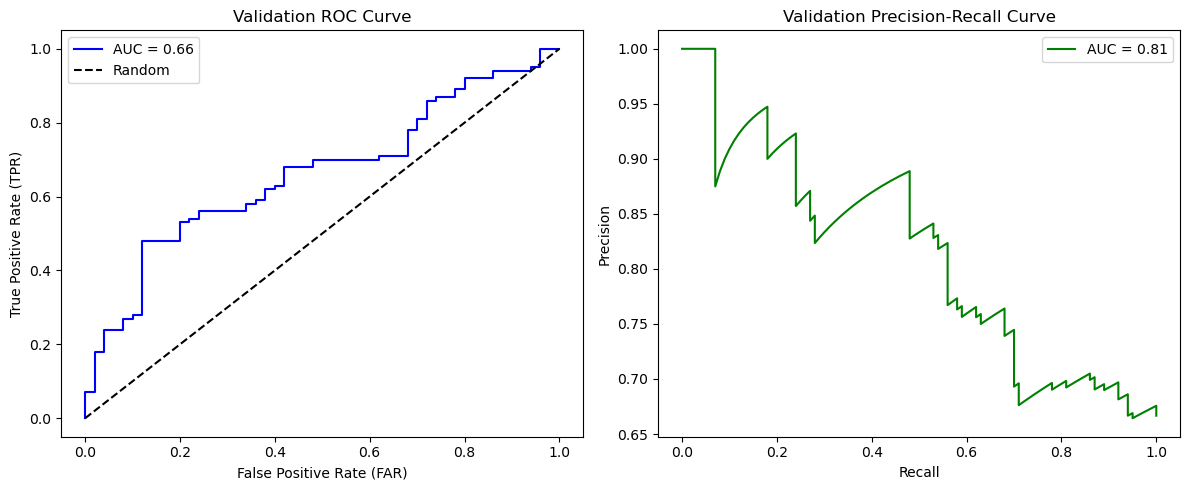

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_20768\41247499.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


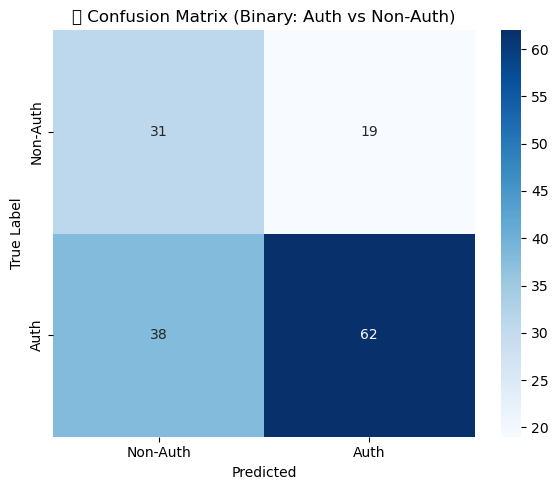

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_20768\1879087496.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


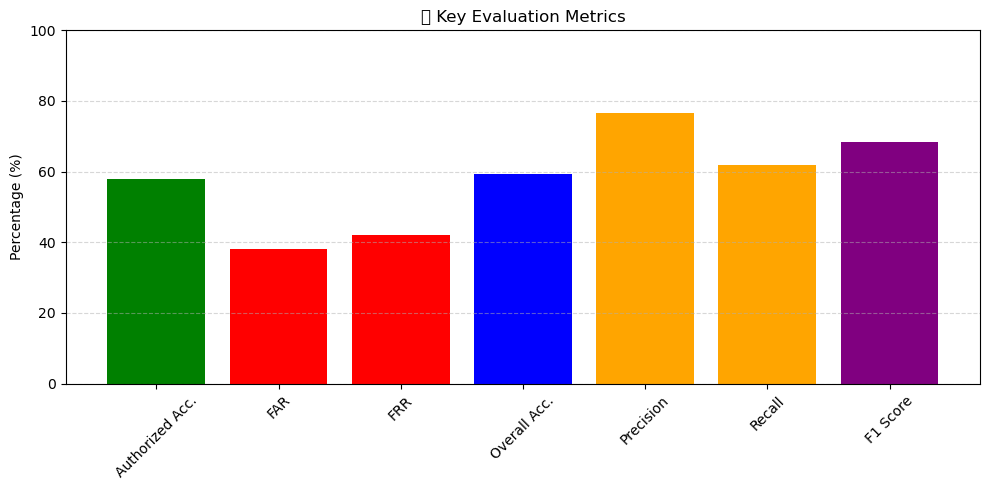

In [73]:

metrics = evaluate_base_model(model, val_loader, threshold=0.87, device=device)
full_evaluation_report(metrics)

FAR vs FRR in softmax

In [40]:
import torch
import torch.nn.functional as F

def build_class_centroids_from_loader(model, loader, device='cuda'):
    """Costruisce i centroidi per ciascuna classe *autorizzata* (label >= 0)
    usando EMBEDDING L2-normalizzati.
    Ritorna:
      - centroids: Tensor [C, D]
      - class_ids: lista ID classe (stesso ordine dei centroidi)
    """
    model.eval()
    sums, counts = {}, {}
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            embeddings = out[1] if (isinstance(out, tuple) and len(out) >= 2) else out
            embeddings = F.normalize(embeddings, p=2, dim=1)
            for e, l in zip(embeddings, labels):
                l = int(l.item())
                if l < 0:      # ignora non autorizzati
                    continue
                if l not in sums:
                    sums[l] = e.detach().clone()
                    counts[l] = 1
                else:
                    sums[l] += e.detach()
                    counts[l] += 1
    if not sums:
        raise RuntimeError("Nessuna classe autorizzata trovata per i centroidi.")
    class_ids = sorted(sums.keys())
    centroids = []
    for cid in class_ids:
        c = sums[cid] / counts[cid]
        centroids.append(F.normalize(c, dim=0))
    centroids = torch.stack(centroids, dim=0)  # [C, D]
    return centroids, class_ids


In [41]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

def evaluate_openset_centroids(
    model,
    val_loader,
    threshold=0.6,
    device='cpu',
    train_loader=None,
    centroids=None,
    class_ids=None,
    print_summary=True,
    return_raw=False
):
    """
    Valutazione open-set basata su cosine vs CENTROIDI.
    - Se 'centroids' e 'class_ids' non sono passati, vengono costruiti da 'train_loader'.
    - Decisione: s_max = max_j cos( e , c_j ); se s_max < threshold => pred = -1 (impostore), altrimenti pred = class_ids[argmax].
    - Metriche: FAR/FRR/accuracy + ROC/PR per *impostor detection* (y_true: 1=genuino, 0=impostore) usando s_max.
    """
    model.eval()

    # --- centroidi ---
    if centroids is None or class_ids is None:
        if train_loader is None:
            raise ValueError("Passa train_loader oppure centroids+class_ids.")
        centroids, class_ids = build_class_centroids_from_loader(model, train_loader, device=device)
    centroids = F.normalize(centroids.to(device), p=2, dim=1)  # [C,D]

    all_preds, all_labels, all_scores = [], [], []

    total_auth = total_unauth = 0
    correct_auth = correct_total = 0
    false_accepts = false_rejects = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            out = model(x)
            emb = out[1] if (isinstance(out, tuple) and len(out) >= 2) else out
            emb = F.normalize(emb, p=2, dim=1)               # [B,D]
            scores = emb @ centroids.T                       # [B,C] cosine
            s_max, j_max = scores.max(dim=1)                 # top-1
            s_max = s_max.detach().cpu().numpy()
            j_max = j_max.detach().cpu().numpy()
            y_np  = y.detach().cpu().numpy()

            for sm, jm, yy in zip(s_max, j_max, y_np):
                pred = class_ids[int(jm)] if sm >= threshold else -1
                all_preds.append(pred)
                all_labels.append(int(yy))
                all_scores.append(float(sm))

                if yy == -1:          # impostore
                    total_unauth += 1
                    if pred != -1:    # false accept
                        false_accepts += 1
                    else:
                        correct_total += 1
                else:                  # genuino
                    total_auth += 1
                    if pred == yy:    # corretto
                        correct_auth += 1
                        correct_total += 1
                    else:
                        false_rejects += 1

    # --- metriche aggregate ---
    overall_acc = 100 * correct_total / (total_auth + total_unauth) if (total_auth + total_unauth) else 0.0
    auth_acc    = 100 * correct_auth  / total_auth if total_auth else 0.0
    far         = 100 * false_accepts / total_unauth if total_unauth else 0.0
    frr         = 100 * false_rejects / total_auth if total_auth else 0.0

    # impostor detection (binary): 1=genuino, 0=impostore
    y_true  = np.array([1 if l != -1 else 0 for l in all_labels], dtype=int)
    y_predb = np.array([1 if p != -1 else 0 for p in all_preds], dtype=int)
    y_scores= np.array(all_scores, dtype=float)

    precision = precision_score(y_true, y_predb, zero_division=0) * 100
    recall    = recall_score(y_true, y_predb, zero_division=0) * 100
    f1        = f1_score(y_true, y_predb, zero_division=0) * 100
    cm        = confusion_matrix(y_true, y_predb)

    # ROC / PR (sui punteggi s_max)
    try:
        roc_auc = float(roc_auc_score(y_true, y_scores))
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    except Exception:
        roc_auc = float('nan'); fpr=tpr=roc_thresholds=np.array([])

    try:
        precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_scores)
        pr_auc = float(auc(recall_curve, precision_curve))
    except Exception:
        precision_curve=recall_curve=pr_thresholds=np.array([]); pr_auc=float('nan')

    if print_summary:
        print("\n--- Open-set Evaluation (centroids, cosine) ---")
        print(f"Threshold: {threshold:.3f}  | Centroidi: {len(class_ids)}")
        print(f"Authorized Accuracy: {auth_acc:.2f}%")
        print(f"False Accept Rate (FAR): {far:.2f}%")
        print(f"False Reject Rate (FRR): {frr:.2f}%")
        print(f"Overall Accuracy: {overall_acc:.2f}%")
        print(f"Precision: {precision:.2f}%  Recall: {recall:.2f}%  F1: {f1:.2f}%")
        print(f"ROC AUC: {roc_auc:.3f}   PR AUC: {pr_auc:.3f}")
        print(f"Confusion Matrix (impostor/genuine):\n{cm}")

    out = {
        'authorized_accuracy': auth_acc,
        'far': far,
        'frr': frr,
        'overall_accuracy': overall_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm.tolist(),
        'all_scores': all_scores,                # s_max (cosine)
        'all_labels': all_labels,                # label originali (-1 impostori)
        'all_preds': all_preds,                  # pred = class_id o -1
        # alias compatibili con il tuo codice precedente:
        'max_probs_list': all_scores,            # alias → ora sono cosine
        'labels_list': [1 if l != -1 else 0 for l in all_labels],
        'fpr': fpr.tolist() if len(fpr) else [],
        'tpr': tpr.tolist() if len(tpr) else [],
        'roc_thresholds': roc_thresholds.tolist() if len(roc_thresholds) else [],
        'precision_curve': precision_curve.tolist() if len(precision_curve) else [],
        'recall_curve': recall_curve.tolist() if len(recall_curve) else [],
        'pr_thresholds': pr_thresholds.tolist() if len(pr_thresholds) else [],
        'prototypes': 'centroids',
        'class_ids': class_ids,
    }
    if return_raw:
        out['y_true'] = y_true
        out['y_pred'] = y_predb
        out['y_scores'] = y_scores

    return out


In [ ]:
# 1) Centroidi dalla GALLERIA (train)
centroids, class_ids = build_class_centroids_from_loader(model, train_loader, device=device)
res = evaluate_openset_centroids(model, val_loader, 0.74, device, centroids=centroids, class_ids=class_ids) #(treshold = EER)



--- Open-set Evaluation (centroids, cosine) ---
Threshold: 0.740  | Centroidi: 100
Authorized Accuracy: 70.00%
False Accept Rate (FAR): 26.00%
False Reject Rate (FRR): 30.00%
Overall Accuracy: 71.33%
Precision: 84.34%  Recall: 70.00%  F1: 76.50%
ROC AUC: 0.734   PR AUC: 0.863
Confusion Matrix (impostor/genuine):
[[37 13]
 [30 70]]


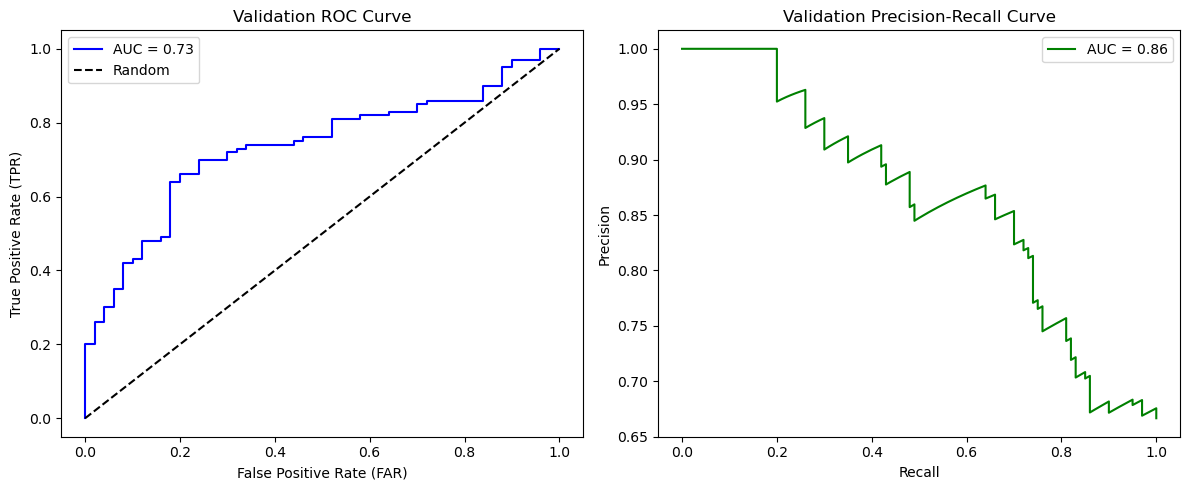

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_20768\41247499.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


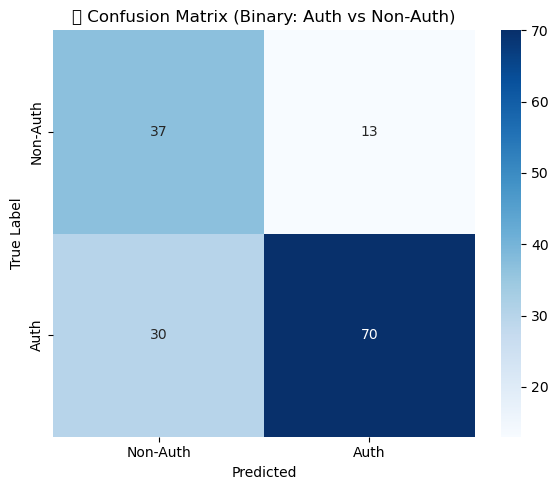

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_20768\1879087496.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


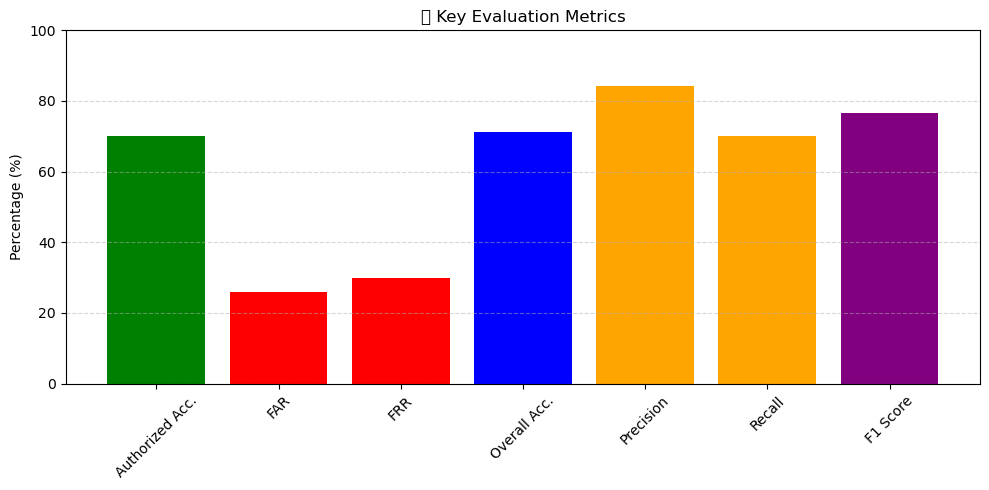

In [45]:
plot_evaluation_curves(res)
plot_confusion_matrix(res['confusion_matrix'])
plot_metric_bars(res)

In [28]:
import torch
import torch.nn.functional as F

def compute_probe_scores_vs_centroids(model, loader, centroids, class_ids, device='cuda'):
    """Per ogni probe calcola:
       - label (int)
       - s_max = max_j cos(emb, centroid_j)
       - rank_pos (1=top1) se genuino, altrimenti None
       - s_target = score contro la classe corretta (se genuino), altrimenti None
    Ritorna: lista di dict.
    """
    model.eval()
    results = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            embeddings = out[1] if (isinstance(out, tuple) and len(out) >= 2) else out
            embeddings = F.normalize(embeddings, p=2, dim=1)
            scores = embeddings @ centroids.T  # [B, C]
            for i in range(scores.size(0)):
                lbl = int(labels[i].item())
                s = scores[i]
                s_max = float(torch.max(s).item())
                rank_pos, s_target = None, None
                if lbl >= 0:
                    try:
                        j = class_ids.index(lbl)
                        s_target = float(s[j].item())
                        rank_pos = 1 + int(torch.sum(s > s[j]).item())
                    except ValueError:
                        pass  # label non in galleria → trattalo come impostore
                results.append({'label': lbl, 's_max': s_max, 'rank_pos': rank_pos, 's_target': s_target})
    return results

import numpy as np
import torch
import torch.nn.functional as F

def compute_probe_stats_with_preds(model, loader, centroids, class_ids, device='cuda'):
    """Ritorna, per ogni probe:
       - label (int, -1 se impostore)
       - s_max (float), pred_idx (int in [0..C-1]), pred_class (class_ids[pred_idx])
       - rank_pos (se genuino), s_target (score verso la classe corretta se genuino)
       - (opz) orig_label_src: id sorgente dell'impostore, se il loader lo fornisce
    """
    model.eval()
    results = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:
                images, labels = batch
                orig_src = None
            else:
                # se il tuo loader restituisce anche l'ID sorgente originale, catturarlo qui
                images, labels, orig_src = batch[0], batch[1], batch[2]
            images, labels = images.to(device), labels.to(device)

            out = model(images)
            emb = out[1] if (isinstance(out, tuple) and len(out) >= 2) else out
            emb = F.normalize(emb, p=2, dim=1)

            scores = emb @ centroids.T  # [B,C] cosine
            pred_vals, pred_idx = torch.max(scores, dim=1)  # top-1
            pred_vals = pred_vals.detach().cpu().numpy()
            pred_idx = pred_idx.detach().cpu().numpy()

            scores_np = scores.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()
            orig_np = None if orig_src is None else np.array(orig_src)

            for i in range(scores_np.shape[0]):
                lbl = int(labels_np[i])
                pidx = int(pred_idx[i])
                smax = float(pred_vals[i])
                rpos, star = None, None
                if lbl >= 0:
                    try:
                        j = class_ids.index(lbl)
                        star = float(scores_np[i, j])
                        rpos = 1 + int(np.sum(scores_np[i, :] > scores_np[i, j]))
                    except ValueError:
                        pass
                rec = {
                    'label': lbl,
                    's_max': smax,
                    'pred_idx': pidx,
                    'pred_class': int(class_ids[pidx]),
                    'rank_pos': rpos,
                    's_target': star
                }
                if orig_np is not None:
                    rec['orig_impostor_id'] = int(orig_np[i])
                results.append(rec)
    return results



In [29]:
import numpy as np
from collections import defaultdict

def doddington_zoo_metrics(results, class_ids, threshold):
    """
    Calcola:
      - goat_rate[c]: quota di probe genuini della classe c che FALLISCONO (FRR_i) a soglia t
      - lamb_rate[c]: quota di probe impostori accettati come c (FPIR per identità) a soglia t
      - wolf_rate[src] (opz.): quota di probe dell'impostore 'src' che superano la soglia impersonando qualcuno
                               (richiede 'orig_impostor_id' nei results)
    Ritorna dict con 'goat_rate', 'lamb_rate', 'wolf_rate'(o None), e conteggi di supporto.
    """
    class_ids = list(class_ids)
    C = len(class_ids)
    idx_of = {c:i for i,c in enumerate(class_ids)}

    # separazione genuini / impostori
    labels = np.array([r['label'] for r in results], dtype=int)
    is_g = labels >= 0
    is_i = ~is_g

    # --- GOAT: FRR_i(t) per classe genuina c ---
    genuini_tot = defaultdict(int)
    genuini_ok  = defaultdict(int)  # accettati correttamente (rank1=c e s_max>=t)

    for r in results:
        if r['label'] >= 0:
            c = r['label']
            genuini_tot[c] += 1
            if (r['s_max'] >= threshold) and (r['rank_pos'] == 1) and (r['pred_class'] == c):
                genuini_ok[c] += 1

    goat_rate = {}
    for c in class_ids:
        tot = genuini_tot.get(c, 0)
        ok  = genuini_ok.get(c, 0)
        goat_rate[c] = float(1.0 - (ok / tot)) if tot > 0 else np.nan  # FRR_i(t)

    # --- LAMB: per ogni classe target c, quante volte un impostore viene accettato come c ---
    impostori_tot = int(np.sum(is_i))
    impostori_acc_come_c = defaultdict(int)

    for r in results:
        if r['label'] < 0:
            if r['s_max'] >= threshold:
                impostori_acc_come_c[r['pred_class']] += 1

    lamb_rate = {}
    for c in class_ids:
        lamb_rate[c] = float(impostori_acc_come_c.get(c, 0) / impostori_tot) if impostori_tot > 0 else np.nan

    # --- WOLF (opzionale): richiede 'orig_impostor_id' nei results ---
    have_src = any(('orig_impostor_id' in r) for r in results if r['label'] < 0)
    wolf_rate = None
    if have_src:
        att_tot = defaultdict(int)
        att_succ = defaultdict(int)
        for r in results:
            if r['label'] < 0 and ('orig_impostor_id' in r):
                src = r['orig_impostor_id']
                att_tot[src] += 1
                if r['s_max'] >= threshold:
                    att_succ[src] += 1
        wolf_rate = {src: (att_succ.get(src,0)/att_tot[src]) for src in att_tot if att_tot[src] > 0}

    return {
        'goat_rate': goat_rate,
        'lamb_rate': lamb_rate,
        'wolf_rate': wolf_rate,
        'support': {
            'genuine_counts': dict(genuini_tot),
            'impostor_count': impostori_tot
        }
    }


In [48]:
import numpy as np

def sweep_watchlist_metrics_multi_k(results, thresholds, ks=(1,5,10)):
    """
    results: output di compute_probe_scores_vs_centroids (lista di dict)
    thresholds: iterable di soglie
    ks: tuple dei rank per cui calcolare DIR@k
    Ritorna: dict con
      - 't' (np.ndarray)
      - 'FPIR' (np.ndarray)  = FAR(t) sugli impostori
      - 'FRR'  (np.ndarray)  = 1 - DIR@1(t)
      - 'GRR'  (np.ndarray)  = 1 - FPIR(t)
      - 'DIR@k' (dict{k: np.ndarray})
      - 'EER', 'EER_t', 'EER_idx'          (calcolati su DIR@1 vs FPIR)
    """
    labels = np.array([r['label'] for r in results], dtype=int)
    is_g = labels >= 0
    is_i = ~is_g
    n_g = int(is_g.sum())
    n_i = int(is_i.sum())
    if n_g == 0 or n_i == 0:
        raise ValueError("Servono sia probe genuini sia impostori.")

    s_max = np.array([r['s_max'] for r in results], dtype=float)
    # rank_pos: NaN per non definiti (impostori o genuini non mappabili)
    rank_pos = np.array([ (r['rank_pos'] if r['rank_pos'] is not None else np.nan) for r in results ], dtype=float)

    thresholds = np.array(list(thresholds), dtype=float)
    FPIR = np.empty_like(thresholds)
    DIRk = {k: np.empty_like(thresholds) for k in ks}

    for idx, t in enumerate(thresholds):
        # impostori accettati
        FPIR[idx] = float((is_i & (s_max >= t)).sum()) / n_i
        # genuini accettati e identificati entro k
        mask_g = is_g & (s_max >= t)
        for k in ks:
            DIRk[k][idx] = float((mask_g & (rank_pos <= k)).sum()) / n_g

    DIR1 = DIRk[min(ks)] if (1 in ks) else np.array([np.nan]*len(thresholds))
    FRR  = 1.0 - DIR1
    GRR  = 1.0 - FPIR

    # EER su (DIR@1, FPIR)
    diff = np.abs(FPIR - FRR)
    eer_idx = int(np.nanargmin(diff))
    EER   = float(0.5*(FPIR[eer_idx] + FRR[eer_idx]))
    EER_t = float(thresholds[eer_idx])

    return {
        't': thresholds, 'FPIR': FPIR, 'FRR': FRR, 'GRR': GRR,
        'DIR@k': DIRk, 'EER': EER, 'EER_t': EER_t, 'EER_idx': eer_idx
    }


In [47]:
import matplotlib.pyplot as plt
import numpy as np


def plot_watchlist_roc_multi(curves_multi, ks=(1,5,10)):
    FPIR = curves_multi['FPIR'] * 100.0
    plt.figure(figsize=(6.2,5.2))
    for k in ks:
        DIRk = curves_multi['DIR@k'][k] * 100.0
        plt.plot(FPIR, DIRk, label=f'DIR@rank-{k}', linewidth=2)
    # marker EER su k=1 (se presente)
    if 1 in ks and 'EER_idx' in curves_multi:
        i = curves_multi['EER_idx']
        plt.scatter([FPIR[i]], [curves_multi['DIR@k'][1][i]*100.0], s=40, color='red', zorder=3)
        plt.annotate(f"EER≈{curves_multi['EER']*100:.2f}%\nt={curves_multi['EER_t']:.3f}",
                     (FPIR[i], curves_multi['DIR@k'][1][i]*100.0),
                     textcoords='offset points', xytext=(8,-10))
    plt.xlabel('FAR / FPIR [%]')
    plt.ylabel('DIR@rank-k [%]')
    plt.title('Open-set (Watchlist) ROC – multi-rank')
    plt.grid(True, ls='--', alpha=0.4)
    plt.legend()
    plt.show()


def plot_score_distributions(results):
    """Distribuzioni dei punteggi come in slide:
       - p(s|H1): per genuini, score verso la classe corretta (s_target)
       - p(s|H0): per impostori, max score (s_max) contro la galleria
    """
    s_target = np.array([r['s_target'] for r in results if (r['s_target'] is not None)], dtype=float)
    s_impostor = np.array([r['s_max'] for r in results if r['label'] < 0], dtype=float)

    plt.figure(figsize=(6,5))
    if len(s_target) > 0:
        plt.hist(s_target, bins=50, alpha=0.6, label='p(s|H1) genuini', density=True)
    if len(s_impostor) > 0:
        plt.hist(s_impostor, bins=50, alpha=0.6, label='p(s|H0) impostori', density=True)
    plt.xlabel('Score (cosine similarity)')
    plt.ylabel('Densità')
    plt.legend()
    plt.title('Distribuzioni dei punteggi')
    plt.show()


In [46]:
def print_operating_point(curves_multi, t_op=None):
    if t_op is None:
        t_op = curves_multi['EER_t']
    t = curves_multi['t']
    i = int(np.argmin(np.abs(t - t_op)))
    vals = {
        't': float(t[i]),
        'DIR@1': float(curves_multi['DIR@k'][1][i]),
        'FPIR' : float(curves_multi['FPIR'][i]),
        'FRR'  : float(curves_multi['FRR'][i]),
        'GRR'  : float(curves_multi['GRR'][i]),
    }
    print(f"[t={vals['t']:.3f}] DIR@1={vals['DIR@1']*100:.2f}%  FPIR={vals['FPIR']*100:.2f}%  "
          f"FRR={vals['FRR']*100:.2f}%  GRR={vals['GRR']*100:.2f}%")
    return vals


In [49]:
def plot_threshold_sweeps_openset(curves_multi):
    t = curves_multi['t']
    DIR1 = curves_multi['DIR@k'][1] * 100.0 if 1 in curves_multi['DIR@k'] else None
    FPIR = curves_multi['FPIR'] * 100.0
    FRR  = curves_multi['FRR']  * 100.0
    GRR  = curves_multi['GRR']  * 100.0

    plt.figure(figsize=(7,5))
    if DIR1 is not None:
        plt.plot(t, DIR1, label='DIR@rank-1 [%]', linewidth=2)
    plt.plot(t, FPIR, label='FPIR [%]', linewidth=2)
    plt.plot(t, FRR,  label='FRR [%]',  linewidth=2)
    plt.plot(t, GRR,  label='GRR [%]',  linewidth=2)
    # punto EER
    i = curves_multi['EER_idx']
    plt.axvline(x=t[i], color='k', ls=':', alpha=0.6)
    plt.annotate(f"EER t={curves_multi['EER_t']:.3f}",
                 (t[i], max(FPIR[i], FRR[i])),
                 textcoords='offset points', xytext=(8,8))
    plt.xlabel('Soglia t')
    plt.ylabel('Percentuale [%]')
    plt.title('Sweep vs soglia: DIR@1, FPIR, FRR, GRR')
    plt.grid(True, ls='--', alpha=0.35)
    plt.legend()
    plt.show()

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_goat_lamb(goat_rate, lamb_rate, top=30):
    # ordina
    goats = sorted([(c,v) for c,v in goat_rate.items() if not np.isnan(v)], key=lambda x: x[1], reverse=True)
    lambs = sorted([(c,v) for c,v in lamb_rate.items() if not np.isnan(v)], key=lambda x: x[1], reverse=True)

    # GOAT
    plt.figure(figsize=(8,4))
    sel = goats[:top]
    plt.bar([str(c) for c,_ in sel], [v for _,v in sel])
    plt.xticks(rotation=90)
    plt.ylabel('FRR_i(t) per classe')
    plt.title(f'Doddington – GOATS (peggiori {min(top,len(sel))})')
    plt.tight_layout()
    plt.show()

    # LAMB
    plt.figure(figsize=(8,4))
    sel = lambs[:top]
    plt.bar([str(c) for c,_ in sel], [v for _,v in sel])
    plt.xticks(rotation=90)
    plt.ylabel('FPIR verso classe (quota impostori accettati come c)')
    plt.title(f'Doddington – LAMBS (peggiori {min(top,len(sel))})')
    plt.tight_layout()
    plt.show()

def scatter_goat_vs_lamb(goat_rate, lamb_rate):
    # scatter FRR_i vs FPIR_i per classe
    keys = sorted(set(k for k in goat_rate.keys() if k in lamb_rate))
    x = np.array([goat_rate[k] for k in keys])
    y = np.array([lamb_rate[k] for k in keys])
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y, keys = x[mask], y[mask], [keys[i] for i,m in enumerate(mask) if m]

    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=20)
    plt.xlabel('GOAT rate = FRR_i(t)')
    plt.ylabel('LAMB rate = FPIR→i(t)')
    plt.title('Doddington – mappa GOAT vs LAMB (per classe)')
    plt.grid(True, ls='--', alpha=0.4)
    plt.show()


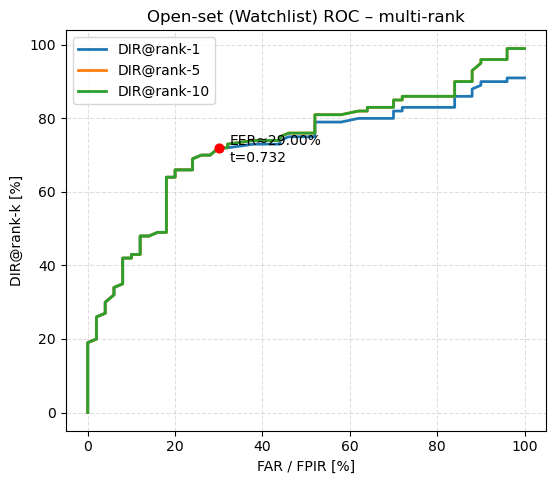

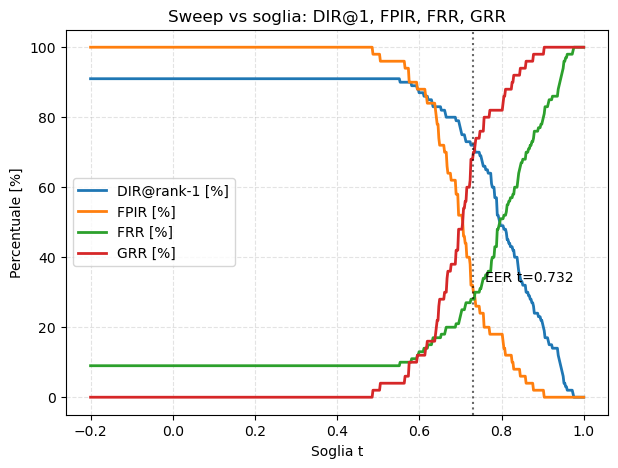

[t=0.732] DIR@1=72.00%  FPIR=30.00%  FRR=28.00%  GRR=70.00%
[t=0.750] DIR@1=69.00%  FPIR=24.00%  FRR=31.00%  GRR=76.00%


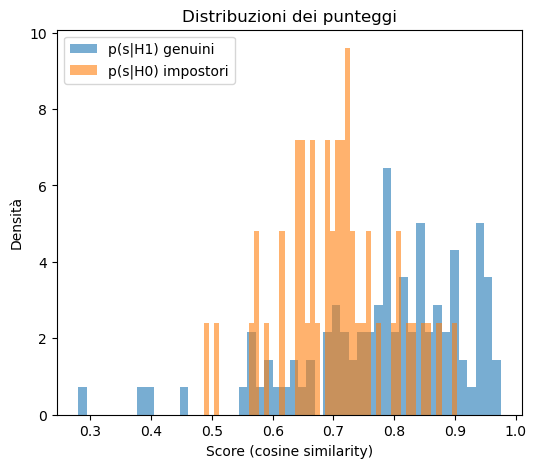

In [ ]:
# 2) Punteggi dei PROBE (val) contro i centroidi
results = compute_probe_scores_vs_centroids(model, val_loader, centroids.to(device), class_ids, device=device)

In [ ]:
# 3) Sweep soglia → metriche (k=1 misura principale)
import numpy as np
thresholds = np.linspace(-0.2, 1.0, 600)  # adatta se necessario
curves_multi = sweep_watchlist_metrics_multi_k(results, thresholds, ks=(1,5,10))

plot_watchlist_roc_multi(curves_multi, ks=(1,5,10))
plot_threshold_sweeps_openset(curves_multi)
print_operating_point(curves_multi)          # usa t_EER
print_operating_point(curves_multi, t_op=0.75)  # oppure a soglia fissa


plot_score_distributions(results)   # p(s|H1) vs p(s|H0)

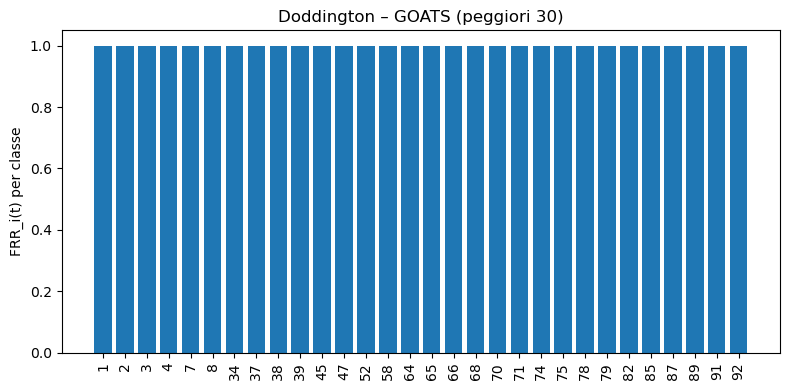

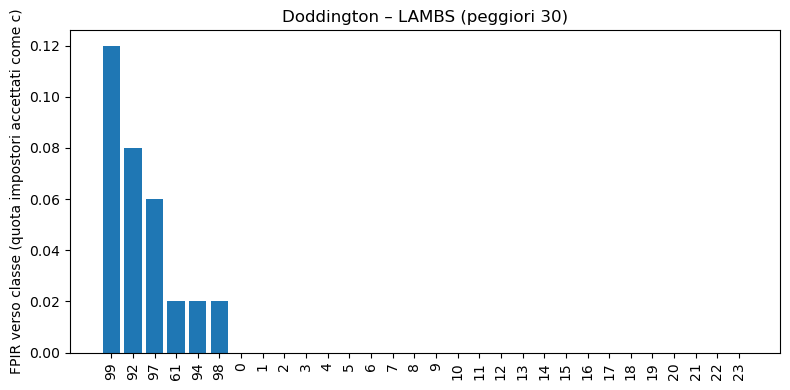

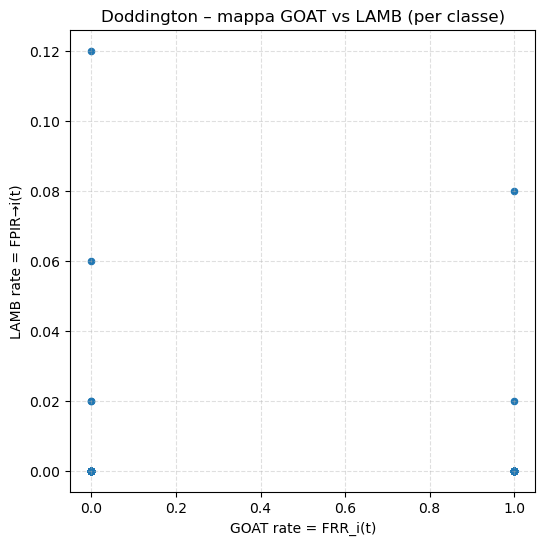

In [35]:
# 2) Statistiche probe→centroidi sul validation (open-set)
stats = compute_probe_stats_with_preds(model, val_loader, centroids.to(device), class_ids, device=device)

# 3) Soglia operativa: usa quella dell’EER che già calcoli (qui esempio t=curves['EER_t'])
#    Se non l'hai ancora calcolata, fai lo sweep come già implementato e prendi la EER_t.
t_oper = 0.738  # <-- SOSTITUISCI con la tua soglia (es. EER_t)

# 4) Doddington’s Zoo
zoo = doddington_zoo_metrics(stats, class_ids, threshold=t_oper)
goat_rate = zoo['goat_rate']   # dict {class_id -> FRR_i(t)}
lamb_rate = zoo['lamb_rate']   # dict {class_id -> FPIR→i(t)}
wolf_rate = zoo['wolf_rate']   # dict opzionale {impostor_src -> successo}, o None

# 5) Plot
plot_goat_lamb(goat_rate, lamb_rate, top=30)
scatter_goat_vs_lamb(goat_rate, lamb_rate)


In [36]:
import numpy as np

# 1) coerenza tra galleria e split
print("n_centroidi:", len(class_ids))
# se usi lo split:
# assert set(class_ids) == set(split['label_map'].values())

# 2) quanti genuini NON appartengono alla galleria?
labels = np.array([r['label'] for r in results])
n_g = int(np.sum(labels >= 0)); n_i = int(np.sum(labels < 0))
not_in_gallery = int(np.sum([(r['label'] >= 0) and (r['label'] not in class_ids) for r in results]))
print("genuini:", n_g, "impostori:", n_i, "genuini fuori galleria:", not_in_gallery)

# 3) verifica che la soglia usata per lo Zoo sia proprio l'EER_t dei medesimi results
def far_frr_at_t(results, t):
    import math
    is_g = labels >= 0; is_i = ~is_g
    s_max = np.array([r['s_max'] for r in results], float)
    rank_pos = np.array([ (r['rank_pos'] if r['rank_pos'] is not None else math.inf) for r in results ])
    FAR = float(np.sum(is_i & (s_max >= t))) / max(1, int(np.sum(is_i)))
    DIR = float(np.sum(is_g & (s_max >= t) & (rank_pos == 1))) / max(1, int(np.sum(is_g)))
    FRR = 1.0 - DIR
    return FAR, FRR

print("EER_t usata:", curves['EER_t'])
print("FAR, FRR a EER_t:", far_frr_at_t(results, curves['EER_t']))


n_centroidi: 100
genuini: 100 impostori: 50 genuini fuori galleria: 0
EER_t usata: 0.7375626043405676
FAR, FRR a EER_t: (0.32, 0.33999999999999997)


In [ ]:
Adapt Treshold to get FAR < target

In [36]:
import numpy as np
from sklearn.metrics import roc_curve

def tune_threshold(scores, labels, far_target=0.05):
    """
    Trova la soglia ottimale per avere FAR < far_target.
    
    scores: array/list di confidence (es. max_probs dal softmax)
    labels: array/list di etichette (1 = genuine, 0 = impostor)
    far_target: massimo FAR ammesso (default 5%)
    """
    scores = np.array(scores)
    labels = np.array(labels)

    # roc_curve usa 1 come positivo, quindi definiamo "genuine"=1, "impostor"=0
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # fpr = FAR, tpr = 1 - FRR
    valid = np.where(fpr <= far_target)[0]
    if len(valid) == 0:
        print("⚠️ Nessuna soglia soddisfa FAR < target!")
        best_idx = np.argmin(fpr)  # prendi la più bassa comunque
    else:
        # scegli quella con recall (tpr) più alto
        best_idx = valid[np.argmax(tpr[valid])]

    best_threshold = thresholds[best_idx]
    best_far = fpr[best_idx]
    best_tpr = tpr[best_idx]
    best_frr = 1 - best_tpr

    print(f"🔎 Threshold ottimale: {best_threshold:.3f}")
    print(f"FAR: {best_far*100:.2f}%  | FRR: {best_frr*100:.2f}%  | Recall: {best_tpr*100:.2f}%")

    return best_threshold


In [37]:
best_thr = tune_threshold(metrics["max_probs_list"], metrics["labels_list"], far_target=0.15)

🔎 Threshold ottimale: 0.998
FAR: 14.00%  | FRR: 48.00%  | Recall: 52.00%


Cosine similarity with centroids

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
)

def build_centroids(model, train_loader, device='cpu'):
    """Raccoglie embeddings dal train_loader e costruisce centroidi per ogni classe.
       Si assume che train_loader fornisca label mappati 0..C-1 (senza -1)."""
    model.eval()
    embeddings_per_class = {}
    counts = {}

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # ottieni logits, embeddings dal modello (assume ritorna (logits, embeddings))
            out = model(images, labels=None)
            if isinstance(out, tuple):
                logits, emb = out
            else:
                # se il modello restituisce solo embeddings
                emb = out
            # gli embeddings dovrebbero essere già normalizzati; se no:
            emb = F.normalize(emb, dim=1)

            for e, l in zip(emb, labels):
                l = int(l.item())
                if l not in embeddings_per_class:
                    embeddings_per_class[l] = e.detach().cpu().numpy().astype(np.float32)
                    counts[l] = 1
                else:
                    embeddings_per_class[l] += e.detach().cpu().numpy().astype(np.float32)
                    counts[l] += 1

    # Centroidi = media normalizzata
    centroids = {}
    for l, s in embeddings_per_class.items():
        vec = s / counts[l]
        vec = vec / (np.linalg.norm(vec) + 1e-12)
        centroids[l] = vec

    # crea array ordinato di centroidi e mappa label->index
    labels_sorted = sorted(centroids.keys())
    centroid_matrix = np.stack([centroids[l] for l in labels_sorted], axis=0)  # shape (C, D)
    label_to_index = {lab: i for i, lab in enumerate(labels_sorted)}
    return centroid_matrix, label_to_index

def evaluate_with_centroids(model, centroid_matrix, label_to_index, val_loader, device='cpu', thresholds=None, target_far=0.05, print_summary=True):
    """
    Calibra threshold se non fornito.
    centroid_matrix: np.array shape (C, D), normalized.
    label_to_index: mapping original_label -> row index in centroid_matrix.
    val_loader yields (images, labels) where impostori hanno label == -1.
    """
    model.eval()
    C, D = centroid_matrix.shape
    centroid_tensor = torch.from_numpy(centroid_matrix).to(device)  # (C, D)

    all_labels = []
    all_max_sim = []   # massimo similarity verso qualsiasi centroid
    all_pred_idx = []  # argmax idx
    all_true_label = []  # original label (or -1)

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            out = model(images, labels=None)
            if isinstance(out, tuple):
                logits, emb = out
            else:
                emb = out
            emb = F.normalize(emb, dim=1)  # (B, D)
            # similarity matrix: (B, C)
            sims = torch.matmul(emb, centroid_tensor.t())  # cos similarity
            max_sims, argmax_idx = torch.max(sims, dim=1)
            for i in range(len(labels)):
                all_true_label.append(int(labels[i].item()))
                all_max_sim.append(float(max_sims[i].cpu().item()))
                all_pred_idx.append(int(argmax_idx[i].cpu().item()))

    all_true_label = np.array(all_true_label)
    all_max_sim = np.array(all_max_sim)
    all_pred_idx = np.array(all_pred_idx)

    # Calibrazione threshold: scegli τ s.t. FAR <= target_far and massimizzi TPR
    # FAR = false accepts / total impostori  => impostori sono true_label == -1
    impostor_mask = (all_true_label == -1)
    genuine_mask = (all_true_label != -1)

    impostor_scores = all_max_sim[impostor_mask] if impostor_mask.any() else np.array([])
    genuine_scores = all_max_sim[genuine_mask] if genuine_mask.any() else np.array([])

    if thresholds is None:
        # candidate thresholds: linspace tra min e max sim
        thresholds = np.linspace(-1.0, 1.0, 2001)

    best_tau = None
    best_tpr = -1.0
    chosen_metrics = None

    total_impostors = len(impostor_scores)
    total_genuine = len(genuine_scores)

    for tau in thresholds:
        # impostor accepted if score >= tau
        fa = np.sum(impostor_scores >= tau) if total_impostors > 0 else 0
        far = fa / total_impostors if total_impostors > 0 else 0.0

        # genuine accepted if score >= tau AND predicted class matches true class
        # dobbiamo ricostruire per genuine: pred class index -> original label mapping
        # but we have label_to_index mapping: need inverse map
        if total_genuine > 0:
            accepted_genuine_mask = genuine_mask & (all_max_sim >= tau)
            # check if argmax matches true class: true_label -> index
            # create mapping array of true_label->index, fill -1 if label not in map
            true_to_idx = np.full_like(all_pred_idx, fill_value=-1)
            for lab, idx in label_to_index.items():
                # mark positions where true label equals lab
                true_to_idx[all_true_label == lab] = idx
            # genuine accepted and correctly predicted:
            correct_and_accepted = np.sum((all_max_sim >= tau) & (true_to_idx == all_pred_idx) & genuine_mask)
            tpr = correct_and_accepted / total_genuine
        else:
            tpr = 0.0

        # choose tau with FAR <= target and max TPR
        if far <= target_far:
            if tpr > best_tpr:
                best_tpr = tpr
                best_tau = tau

    # if none satisfy FAR <= target, choose tau maximizing (TPR - FAR) or just be conservative pick max tau
    if best_tau is None:
        # fallback: choose tau that minimizes FAR-FRR tradeoff (or choose high tau)
        # choose tau that gives minimal (FAR - target_far)^2 + (1-TPR)^2
        best_score = None
        for tau in thresholds:
            fa = np.sum(impostor_scores >= tau) if total_impostors > 0 else 0
            far = fa / total_impostors if total_impostors > 0 else 0.0
            # tpr as above
            if total_genuine > 0:
                correct_and_accepted = np.sum((all_max_sim >= tau) & (true_to_idx == all_pred_idx) & genuine_mask)
                tpr = correct_and_accepted / total_genuine
            else:
                tpr = 0.0
            score = (far - target_far)**2 + (1 - tpr)**2
            if best_score is None or score < best_score:
                best_score = score
                best_tau = tau

    tau = best_tau

    # Ora calcola metriche finali con tau
    # predicted open-set: pred_label = argmax_idx if sim>=tau else -1
    pred_open = np.where(all_max_sim >= tau, all_pred_idx, -1)
    true_open = all_true_label

    # Binary for impostor detection: 1 genuine, 0 impostor
    y_true_bin = np.array([0 if t == -1 else 1 for t in true_open])
    y_pred_bin = np.array([0 if p == -1 else 1 for p in pred_open])

    # confusion matrix for open-set detection (impostor/genuine)
    cm = confusion_matrix(y_true_bin, y_pred_bin)

    # compute FAR / FRR:
    # FAR = false accepts / total impostors
    fp = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    fn = np.sum((y_true_bin == 1) & (y_pred_bin == 0))
    tn = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    tp = np.sum((y_true_bin == 1) & (y_pred_bin == 1))

    FAR = 100.0 * (fp / (fp + tn)) if (fp + tn) > 0 else 0.0
    FRR = 100.0 * (fn / (fn + tp)) if (fn + tp) > 0 else 0.0
    overall_acc = 100.0 * (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0) * 100
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0) * 100
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0) * 100

    if print_summary:
        print("--- Embedding-based Open-set Evaluation ---")
        print(f"Chosen tau (cosine): {tau:.4f}")
        print(f"FAR: {FAR:.2f}%   FRR: {FRR:.2f}%   Overall Acc: {overall_acc:.2f}%")
        print(f"Precision: {precision:.2f}%  Recall: {recall:.2f}%  F1: {f1:.2f}%")
        print("Confusion matrix (impostor/genuine):")
        print(cm)

    out = {
        'tau': tau,
        'FAR': FAR, 'FRR': FRR, 'overall_acc': overall_acc,
        'precision': precision, 'recall': recall, 'f1': f1, 'cm': cm,
        'all_max_sim': all_max_sim, 'all_true_label': all_true_label, 'all_pred_idx': all_pred_idx
    }
    return out

# -------------------------
# Esempio d'uso:
# -------------------------
centroid_matrix, label_to_index = build_centroids(model, train_loader, device=device)
res = evaluate_with_centroids(model, centroid_matrix, label_to_index, val_loader, device=device, target_far=0.25)


--- Embedding-based Open-set Evaluation ---
Chosen tau (cosine): 0.7650
FAR: 24.00%   FRR: 25.00%   Overall Acc: 75.33%
Precision: 86.21%  Recall: 75.00%  F1: 80.21%
Confusion matrix (impostor/genuine):
[[38 12]
 [25 75]]


Similarity distribution with centroids (genuines vs impostors)

In [56]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

# -------------------- CONFIG (allinea a demo) --------------------
DATA_ROOT      = '../../IAM+RIMES'          # root del dataset (ImageFolder)
SPLIT_PATH     = 'splits/IAM+RIMES.pth'     # stesso split usato in app/test_set
MODEL_PATH     = '../demo/arcface_full_model.pth'   # modello salvato intero (torch.save(model))
OUT_NPY_NAMES  = 'author_centroids_names.npy'  # output: chiavi = NOME classe
OUT_NPY_IDS    = 'author_centroids_ids.npy'    # output: chiavi = new_id (ricodificati)
IMG_SIZE       = 128
BATCH_SIZE     = 64
NUM_WORKERS    = 0
DEVICE         = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED           = 42
LIMIT_BATCHES  = None   # es. 10 per test rapido; None per tutto il train

torch.manual_seed(SEED)
np.random.seed(SEED)

# -------------------- Utils --------------------
def build_preprocess_from_model(model, img_size=128):
    """
    Preprocess allineato al training:
    - se conv1=1 -> grayscale 1 canale, Normalize((0.5,), (0.5,))
    - se conv1=3 -> duplica il grigio su 3 canali, Normalize([0.5]*3, [0.5]*3)
    (Niente mean/std ImageNet.)
    """
    in_ch = 3
    try:
        in_ch = model.backbone.conv1.in_channels
    except Exception:
        pass

    if in_ch == 1:
        tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
        mode = "L"
    else:
        tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
        mode = "RGB"
    return tf, mode, in_ch

class TransformedSubset(torch.utils.data.Dataset):
    """Applica transform e rimappa le label originali a new_id; -1 se non autorizzato."""
    def __init__(self, subset, transform, label_map):
        self.subset = subset
        self.transform = transform
        self.label_map = label_map  # dict: original_idx -> new_id (solo autorizzati)
    def __getitem__(self, idx):
        img, orig_label = self.subset[idx]
        new_label = self.label_map.get(orig_label, -1)
        return self.transform(img), new_label   # Niente .convert('L'): lo decide il transform
    def __len__(self):
        return len(self.subset)

def forward_to_embeddings(model: nn.Module, images: torch.Tensor) -> torch.Tensor:
    """
    Estrae gli EMBEDDING evitando ArcFace/logits:
    usa model.backbone -> model.embedding_layer -> L2 normalize.
    Se questi attributi non esistono, cade su model(images) e prende embeddings dall'output.
    """
    with torch.no_grad():
        if hasattr(model, "backbone") and hasattr(model, "embedding_layer"):
            feats = model.backbone(images)
            emb = model.embedding_layer(feats)
        else:
            out = model(images)
            if isinstance(out, tuple) and len(out) >= 2:
                # supponiamo (logits, embeddings)
                emb = out[1]
            else:
                emb = out
        emb = F.normalize(emb, p=2, dim=1)
    return emb

def l2_np(v, eps=1e-8):
    v = np.asarray(v, dtype=np.float32)
    n = np.linalg.norm(v) + eps
    return v / n

# -------------------- Main --------------------
def main():
    # Path assoluti per chiarezza
    print(f"[INFO] CWD: {os.getcwd()}")
    print(f"[INFO] Split: {os.path.abspath(SPLIT_PATH)}")
    print(f"[INFO] Modello: {os.path.abspath(MODEL_PATH)}")

    if not os.path.isfile(SPLIT_PATH):
        raise FileNotFoundError(f"Split non trovato: {SPLIT_PATH}")
    if not os.path.isfile(MODEL_PATH):
        raise FileNotFoundError(f"Modello non trovato: {MODEL_PATH}")

    # Dataset base e split
    dataset = ImageFolder(root=DATA_ROOT)  # senza transform
    split = torch.load(SPLIT_PATH, map_location='cpu')
    train_indices = split['train_indices']
    label_map     = split['label_map']     # {original_idx -> new_id} solo autorizzati

    # Mappature
    authorized_orig_ids = set(label_map.keys())   # original_label_idx
    new_to_orig = {new: orig for orig, new in label_map.items()}
    idx_to_name = dataset.classes                 # original_label_idx -> nome cartella

    # Subset train e DataLoader
    train_subset = Subset(dataset, train_indices)

    # Carica modello e preprocess coerente
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    if not isinstance(model, nn.Module):
        raise TypeError("MODEL_PATH non contiene un torch.nn.Module (hai salvato solo lo state_dict?).")
    model.eval().to(DEVICE)

    preprocess, color_mode, in_ch = build_preprocess_from_model(model, IMG_SIZE)
    print(f"[INFO] Device: {DEVICE} | conv1.in_channels={in_ch} | preprocess mode={color_mode}")

    train_data = TransformedSubset(train_subset, preprocess, label_map)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=(DEVICE=='cuda'))

    # Debug primo batch
    for images, labels in train_loader:
        print(f"[DEBUG] Primo batch shape: {tuple(images.shape)} (atteso [B,{in_ch},{IMG_SIZE},{IMG_SIZE}])")
        break

    # Contenitori centroidi
    centroids = {}
    counts = {}

    # Progress (senza dipendenze esterne)
    total_batches = (len(train_data) + BATCH_SIZE - 1) // BATCH_SIZE
    print(f"[INFO] Batch totali: {total_batches} (BATCH_SIZE={BATCH_SIZE})")

    processed_batches = 0
    try:
        for bidx, (images, labels) in enumerate(train_loader, 1):
            # Opzione per run veloce
            if LIMIT_BATCHES is not None and bidx > LIMIT_BATCHES:
                print(f"[INFO] LIMIT_BATCHES={LIMIT_BATCHES} raggiunto, esco dal loop.")
                break

            # Filtra solo autorizzati
            mask = labels >= 0
            if not mask.any():
                continue

            images = images[mask].to(DEVICE, non_blocking=True)
            labels = labels[mask].to(DEVICE, non_blocking=True)

            # Embedding
            embeddings = forward_to_embeddings(model, images)  # [m, d]

            # Accumulo per new_id
            for e, l in zip(embeddings, labels):
                l = int(l.item())  # new_id ricodificato
                if l not in centroids:
                    centroids[l] = e.detach().cpu()
                    counts[l] = 1
                else:
                    centroids[l] += e.detach().cpu()
                    counts[l] += 1

            processed_batches += 1
            if bidx % 20 == 0 or bidx == total_batches:
                print(f"[PROGRESS] batch {bidx}/{total_batches} "
                      f"(centroidi parziali: {len(centroids)})")

        if not centroids:
            raise RuntimeError("Nessun embedding raccolto: verifica che train_loader contenga autorizzati.")

        # Media + L2 finale
        for l in list(centroids.keys()):
            centroids[l] /= counts[l]
            centroids[l] = F.normalize(centroids[l], dim=0)

        # Diagnostica dimensione embedding
        dims = {t.numel() for t in centroids.values()}
        if len(dims) != 1:
            raise RuntimeError(f"Embedding dimension non uniforme nei centroidi: {dims}")
        embed_dim = dims.pop()
        print(f"[INFO] Centroidi calcolati: {len(centroids)} | dim={embed_dim}")

        # Mapping new_id -> NOME classe
        author_centroids_names = {}
        for new_id, vec in centroids.items():
            if new_id not in new_to_orig:
                continue
            orig_idx = new_to_orig[new_id]
            if orig_idx not in authorized_orig_ids:
                continue
            name = idx_to_name[orig_idx]
            author_centroids_names[name] = vec.numpy()

        if not author_centroids_names:
            raise RuntimeError("Nessun centroide mappato a NOME: controlla label_map/new_to_orig e split.")

        # Opzionale: dizionario con chiavi = new_id
        author_centroids_ids = {int(k): v.numpy() for k, v in centroids.items()}

        # Salvataggio
        np.save(OUT_NPY_NAMES, author_centroids_names)
        np.save(OUT_NPY_IDS, author_centroids_ids)

        print(f"[OK] Salvati:\n - {os.path.abspath(OUT_NPY_NAMES)} (chiavi = NOME)\n"
              f" - {os.path.abspath(OUT_NPY_IDS)} (chiavi = new_id)")
        print(f"Esempio chiavi (names): {list(author_centroids_names.keys())[:10]}")

        # Copertura attesa
        expected_auth = len(authorized_orig_ids)
        got_names = len(author_centroids_names)
        if got_names != expected_auth:
            names_expected = set(idx_to_name[o] for o in authorized_orig_ids)
            missing = sorted(list(names_expected - set(author_centroids_names.keys())))[:10]
            print(f"[WARN] Autorizzati nello split: {expected_auth} | Centroidi a nome: {got_names}")
            if missing:
                print(f"[INFO] Esempi mancanti (max 10): {missing}")

    finally:
        # Salvataggio parziale (se qualcosa va storto)
        if centroids:
            tmp_path = OUT_NPY_IDS + ".partial.npy"
            np.save(tmp_path, {int(k): v.numpy() for k, v in centroids.items()})
            print(f"[SAFEGUARD] Parziale salvato: {os.path.abspath(tmp_path)}")


main()


[INFO] CWD: c:\Users\Giuseppe\Documents\handwriting_reco_project\handwriting-reco-project\handwriting-recognition\model
[INFO] Split: c:\Users\Giuseppe\Documents\handwriting_reco_project\handwriting-reco-project\handwriting-recognition\model\splits\IAM+RIMES.pth
[INFO] Modello: c:\Users\Giuseppe\Documents\handwriting_reco_project\handwriting-reco-project\handwriting-recognition\demo\arcface_full_model.pth
[INFO] Device: cpu | conv1.in_channels=3 | preprocess mode=RGB
[DEBUG] Primo batch shape: (64, 3, 128, 128) (atteso [B,3,128,128])
[INFO] Batch totali: 9 (BATCH_SIZE=64)
[PROGRESS] batch 9/9 (centroidi parziali: 100)
[INFO] Centroidi calcolati: 100 | dim=256
[OK] Salvati:
 - c:\Users\Giuseppe\Documents\handwriting_reco_project\handwriting-reco-project\handwriting-recognition\model\author_centroids_names.npy (chiavi = NOME)
 - c:\Users\Giuseppe\Documents\handwriting_reco_project\handwriting-reco-project\handwriting-recognition\model\author_centroids_ids.npy (chiavi = new_id)
Esempio ch

In [48]:
torch.save(model, "arcface.pth")

KNN Open set evaluation

In [43]:
import torch
import torch.nn.functional as F
from collections import Counter

def knn_open_set_evaluation(model, train_loader, val_loader, K=3, tau=0.8, device='cuda'):
    model.eval()
    # --- Step 1: calcola embeddings del train set ---
    train_embeddings, train_labels = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            logits, embeddings = model(images, labels=None)
            embeddings = F.normalize(embeddings, p=2, dim=1)
            train_embeddings.append(embeddings.cpu())
            train_labels.append(labels)
    train_embeddings = torch.cat(train_embeddings, dim=0)  # [N_train, D]
    train_labels = torch.cat(train_labels, dim=0)          # [N_train]

    # --- Step 2: valida su val_loader ---
    correct_auth = 0
    false_accepts = 0
    false_rejects = 0
    total_auth = 0
    total_unauth = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            logits, embeddings = model(images, labels=None)
            embeddings = F.normalize(embeddings, p=2, dim=1)

            # calcola la similitudine cosine con tutte le embeddings train
            sim_matrix = embeddings @ train_embeddings.T  # [batch, N_train]

            for i in range(embeddings.size(0)):
                sims = sim_matrix[i]  # [N_train]
                topk_vals, topk_idx = torch.topk(sims, K)
                topk_labels = train_labels[topk_idx]

                # voto della maggioranza
                vote = Counter(topk_labels.tolist())
                pred_label, count = vote.most_common(1)[0]

                # applica soglia di similitudine
                if topk_vals.mean().item() < tau:
                    pred_label = -1  # rifiuta come impostore

                label = labels[i].item()
                if label == -1:  # sample non autorizzato
                    total_unauth += 1
                    if pred_label != -1:
                        false_accepts += 1
                else:
                    total_auth += 1
                    if pred_label == label:
                        correct_auth += 1
                    else:
                        false_rejects += 1

    auth_acc = 100 * correct_auth / total_auth if total_auth > 0 else 0
    far = 100 * false_accepts / total_unauth if total_unauth > 0 else 0
    frr = 100 * false_rejects / total_auth if total_auth > 0 else 0

    print(f"K-NN Open-set Eval: K={K}, tau={tau:.2f} -> Auth Acc: {auth_acc:.2f}%, FAR: {far:.2f}%, FRR: {frr:.2f}%")
    return auth_acc, far, frr


In [44]:
auth_acc, far, frr = knn_open_set_evaluation(model, train_loader, val_loader, K=3, tau=0.7, device=device)


K-NN Open-set Eval: K=3, tau=0.70 -> Auth Acc: 79.00%, FAR: 58.00%, FRR: 21.00%


Debug 

In [ ]:
model = ArcFaceNet(num_classes=100, embedding_dim=256).to(device)
state_dict = torch.load("arcface_improved.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

all_logits = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits, embeddings = model(images, labels=None)  # output ArcFace
        # logits senza softmax, max logits = cosθ * s
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

all_logits = torch.cat(all_logits, dim=0).numpy()  # shape [N, num_classes]
all_labels = torch.cat(all_labels, dim=0).numpy()  # shape [N]
